Give it your best shot notebook

In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, brier_score_loss, log_loss
import sys, os
sys.path.append(os.path.abspath('..'))
from ift6758.data.feature_engineering_pt2 import feature_engineering_two
import ift6758.data.advanced_models as adv
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from termcolor import colored
from feature_engine.selection import MRMR
import plotly as plt

<b> Data Handling: Downstream of all other tasks in this notebook </b>

In [5]:
df2 = feature_engineering_two(years = range(2016, 2020))
df2.head(10)
df2.columns

Index(['game_id', 'season', 'game_time', 'period', 'period_time', 'event_type',
       'team_id', 'team_name', 'coordinates_x', 'coordinates_y', 'shooter',
       'goalie', 'shot_type', 'empty_net', 'strength', 'situation_code',
       'previous_event_name', 'previous_event_x', 'previous_event_y',
       'previous_event_timeperiod', 'isHomeTeam', 'friendly_skaters',
       'opponent_skaters', 'zone_code', 'current_event_timeseconds',
       'previous_event_timeseconds', 'time_since_last_event', 'rebound',
       'distance_from_last_event', 'angle_shot_prev', 'angle_shot', 'speed',
       'angle_change', 'distance_shot', 'is_goal', 'game_seconds_true'],
      dtype='object')

In [6]:
X = df2[['game_time', 'period','period_time', 'coordinates_x','coordinates_y',
         'distance_shot', 'angle_shot','shot_type','previous_event_name',
         'previous_event_timeperiod','friendly_skaters','opponent_skaters','previous_event_timeseconds',
         'previous_event_x','previous_event_y','distance_from_last_event', 'time_since_last_event',
         'rebound','angle_change','speed']]
X = X.copy()
X['rebound'] = X['rebound'].astype(int)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns
median_values = X[numerical_cols].median()
X.loc[:, numerical_cols] = X[numerical_cols].fillna(median_values)
X.loc[:, categorical_cols] = X[categorical_cols].fillna('Unknown')
X = adv._calculate_time_second(X)
X = adv._calculate_period_second(X)
X = X.drop(columns=['game_time', 'period_time', 'previous_event_timeperiod'])
y = (df2['event_type'] == 'goal').astype(int)


In [7]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
exclude_cols = ['shot_type', 'previous_event_name','rebound']
num_cols = [
    col for col in X_train2.columns
    if col not in exclude_cols and X_train2[col].dtype in ['float64', 'int64']
]
scaler = StandardScaler()
X_train2[num_cols] = scaler.fit_transform(X_train2[num_cols])
X_val2[num_cols] = scaler.transform(X_val2[num_cols])
X_train2, ohe = adv.change_to_one_hot(X_train2, ['shot_type', 'previous_event_name'], ohe=None)
X_val2, _ = adv.change_to_one_hot(X_val2, ['shot_type', 'previous_event_name'], ohe=ohe)
X_train2.head(10)

,period,coordinates_x,coordinates_y,distance_shot,angle_shot,friendly_skaters,opponent_skaters,previous_event_timeseconds,previous_event_x,previous_event_y,...,previous_event_name_giveaway,previous_event_name_goal,previous_event_name_hit,previous_event_name_missed-shot,previous_event_name_penalty,previous_event_name_period-end,previous_event_name_period-start,previous_event_name_shot-on-goal,previous_event_name_stoppage,previous_event_name_takeaway
17006,-0.053662,0.582492,1.679621,1.432915,0.665744,0.164325,0.361880,699,0.566449,1.451032,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40406,-1.196334,0.645431,-0.320308,0.763625,-0.589362,0.164325,0.361880,577,1.291951,-1.018099,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
59945,-0.053662,-1.116860,-0.951864,-0.445681,-0.625567,0.164325,-1.301132,1069,-1.010729,-0.753550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3086,-1.196334,-1.038187,1.048064,-0.180596,-0.577706,0.164325,0.361880,1032,-1.452339,-0.841733,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217262,-0.053662,-1.132595,0.679656,-0.659648,-0.717970,0.164325,0.361880,261,-0.616434,1.274665,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58343,-1.196334,1.086004,1.521732,0.069960,1.885873,0.164325,0.361880,16,-0.206368,-0.092175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108631,-0.053662,-1.038187,-0.162419,-0.564989,-0.897786,0.164325,0.361880,603,-1.058044,0.172375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12624,1.089009,-1.289943,1.416472,-0.317097,-0.494644,2.297199,0.361880,1069,-1.073816,0.921932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69063,-1.196334,-1.305677,-0.004530,-1.472314,-0.954629,0.164325,0.361880,594,-0.001335,-0.003992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
114726,-1.196334,-1.006717,-0.057159,-0.468680,-0.935432,-1.968549,0.361880,1045,0.361416,0.172375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<b> Evaluation Model functions </b>

In [8]:
def evaluate_model_scores(name, y_true, y_pred, y_pred_proba):
    '''Evaluates each model based on the metrics set (AUC, F1 and ACC)'''
    auc = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(colored(f"\n{name}", "cyan", attrs=["bold"]))
    print(colored("-" * 60, "yellow"))
    print(colored(f"Validation AUC: {auc:.4f}", "green"))
    print(colored(f"Validation F1 : {f1:.4f}", "green"))
    print(colored(f"Validation Acc: {acc:.4f}", "green"))

def evaluate_model_scores_two(name, y_true, y_pred, y_pred_proba):
    '''Evaluates each model based on the metrics set (AUC, F1 and ACC)'''
    auc = roc_auc_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    brier_score_val= brier_score_loss(y_true, y_pred_proba)
    log_loss_acc = log_loss(y_true, y_pred)
    print(colored(f"\n{name}", "cyan", attrs=["bold"]))
    print(colored("-" * 60, "yellow"))
    print(colored(f"Validation AUC: {auc:.4f}", "green"))
    print(colored(f"Validation F1 : {f1:.4f}", "green"))
    print(colored(f"Validation Acc: {acc:.4f}", "green"))
    print(colored(f"Briars Acc: {brier_score_val:.4f}", "green"))
    print(colored(f"Log Loss Acc: {log_loss_acc:.4f}", "green"))

<b> Models Functions </b>

In [9]:

results = {}

def run_models(X_train2, y_train2, X_val2, y_val2, added_metric=False, use_gridsearch=False, cv=3):
    best_overall_model = None
    best_overall_score = -float("inf")

    models = {
        "Ridge": CalibratedClassifierCV(RidgeClassifier(random_state=42), cv=5),
        "SGD": SGDClassifier(loss='log_loss', max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
        "MLP": MLPClassifier(hidden_layer_sizes=(32, 16), activation='relu', solver='adam', alpha=1e-4,
                             learning_rate_init=1e-3, max_iter=200, random_state=42),
    }

    param_grids = {
        "Ridge": {'model__estimator__alpha': [0.1, 1.0, 10.0]},
        "SGD": {'model__alpha': [1e-4, 1e-3, 1e-2]},
        "Random Forest": {'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]},
        "XGBoost": {'model__n_estimators': [100, 200], 'model__max_depth': [3, 5, 7]},
        "CatBoost": {'model__depth': [4, 6, 8], 'model__learning_rate': [0.01, 0.1]},
        "MLP": {'model__hidden_layer_sizes': [(32,), (64, 32)], 'model__alpha': [1e-4, 1e-3]},
    }

    for name, model in models.items():
        print(f"\n{name}")
        pipe = Pipeline([('model', model)])
        if use_gridsearch:
            grid = param_grids.get(name, {})
            gs = GridSearchCV(
                estimator=pipe,
                param_grid=grid,
                scoring="accuracy",
                cv=cv,
                n_jobs=-1,
                refit=True,
                verbose=0,
            )
            try:
                gs.fit(X_train2, y_train2)
                y_pred = gs.predict(X_val2)
                print(f"Best CV score: {gs.best_score_:.4f}")
                print(f"Best Params: {gs.best_params_}")
                best_model = gs.best_estimator_
            except Exception as e:
                print(f"Skipped {name} — error: {e}")
                continue
        else:
            try:
                pipe.fit(X_train2, y_train2)
                best_model = pipe
            except Exception as e:
                print(f"Skipped {name} — error: {e}")
                continue

        try:
            y_pred_proba = best_model.predict_proba(X_val2)[:, 1]
            y_pred = (y_pred_proba > 0.5).astype(int)
            if added_metric:
                evaluate_model_scores_two(name, y_val2, y_pred, y_pred_proba)
            else:
                evaluate_model_scores(name, y_val2, y_pred, y_pred_proba)
                
            acc = accuracy_score(y_val2, y_pred)
            roc_auc = roc_auc_score(y_val2, y_pred_proba)

            print(f"Validation Accuracy: {acc:.4f}")
            print(f"Validation ROC AUC: {roc_auc:.4f}")

            results[name] = {
                "model": best_model,
                "accuracy": acc,
                "roc_auc": roc_auc,
                "cv_best_score": getattr(gs, "best_score_", None) if use_gridsearch else None,
                "best_params": getattr(gs, "best_params_", None) if use_gridsearch else None,
            }
            
            if roc_auc > best_overall_score:
                best_overall_score = roc_auc
                best_overall_model = best_model
                
        except Exception as e:
            print(f"Skipped {name} — error: {e}")
        
    return best_overall_model

<b> Plots </b>

In [10]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model", figsize=(6, 5)):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})", lw=2)
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

<h1> Testing with several models </h1>

In [11]:
gr_best_model, gr_X_val, gr_y_val = run_models(X_train2, y_train2, X_val2, y_val2, added_metric=True, use_gridsearch=True), X_val2, y_val2


Ridge
Best CV score: 0.9052
Best Params: {'model__estimator__alpha': 1.0}

Ridge
------------------------------------------------------------
Validation AUC: 0.7272
Validation F1 : 0.0346
Validation Acc: 0.9052
Briars Acc: 0.0804
Log Loss Acc: 3.4163
Validation Accuracy: 0.9052
Validation ROC AUC: 0.7272

SGD
Best CV score: 0.9059
Best Params: {'model__alpha': 0.01}

SGD
------------------------------------------------------------
Validation AUC: 0.6687
Validation F1 : 0.0008
Validation Acc: 0.9060
Briars Acc: 0.0849
Log Loss Acc: 3.3872
Validation Accuracy: 0.9060
Validation ROC AUC: 0.6687

Random Forest
Best CV score: 0.9108
Best Params: {'model__max_depth': 20, 'model__n_estimators': 100}

Random Forest
------------------------------------------------------------
Validation AUC: 0.7663
Validation F1 : 0.1296
Validation Acc: 0.9107
Briars Acc: 0.0749
Log Loss Acc: 3.2194
Validation Accuracy: 0.9107
Validation ROC AUC: 0.7663

XGBoost
Best CV score: 0.9110
Best Params: {'model__max_

<h1> Feature Relevance and Selection Experiments </h1>

<b> Training a Random Forest and seing feature relevance and retraining </b> 

In [12]:
import matplotlib.pyplot as plt
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train2, y_train2)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


distance_shot                        0.081917
game_time_seconds                    0.072186
speed                                0.070245
distance_from_last_event             0.069030
angle_shot                           0.067349
period_time_seconds                  0.062807
previous_event_timeperiod_seconds    0.061053
previous_event_timeseconds           0.061004
time_since_last_event                0.057841
previous_event_x                     0.056040
dtype: float64


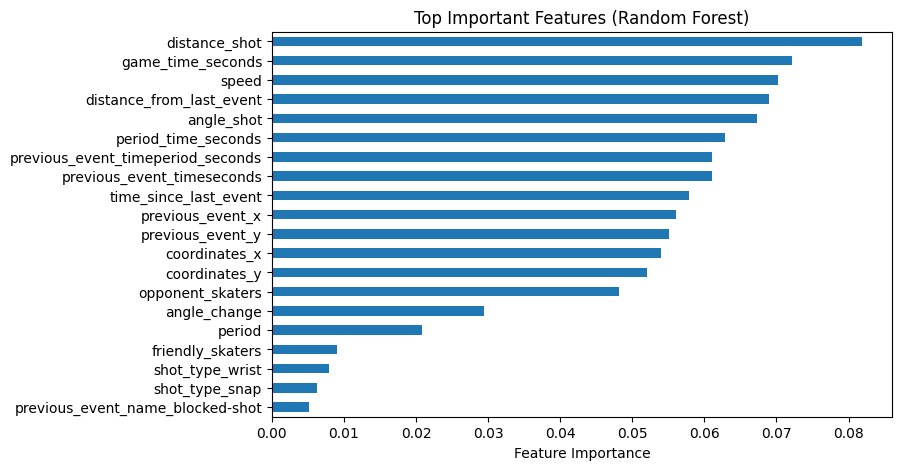

In [13]:
importances = pd.Series(rf.feature_importances_, index=X_train2.columns)
importances = importances.sort_values(ascending=False)
print(importances.head(10))
plt.figure(figsize=(8, 5))
importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top Important Features (Random Forest)")
plt.show()

<b> <u> Computing MRMR and retraining</u> </b>

In [14]:
selection = MRMR(method="FCQ", regression=False, max_features=20)
selection.fit(X_train2, y_train2)

,variables,None
,method,'FCQ'
,max_features,20
,discrete_features,'auto'
,n_neighbors,3
,scoring,'roc_auc'
,cv,3
,param_grid,None
,regression,False
,confirm_variables,False
,random_state,None


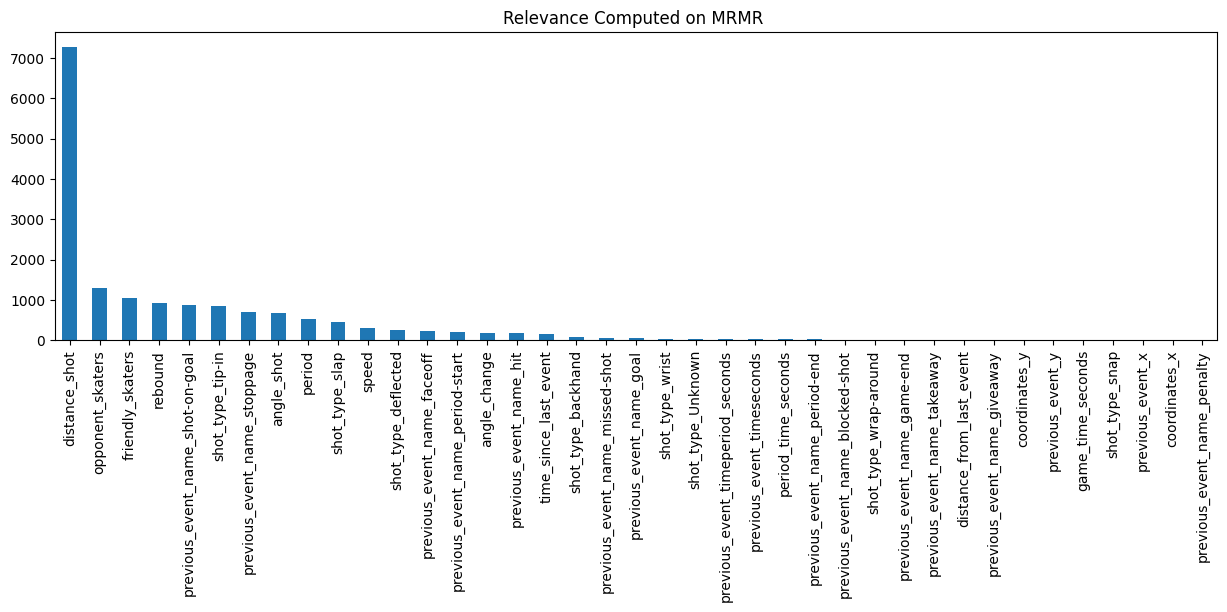

In [15]:
pd.Series(selection.relevance_, index=selection.variables_).sort_values(ascending=False).plot.bar(figsize=(15, 4))
plt.title("Relevance Computed on MRMR ")
plt.show()


In [16]:
np.sum ( selection.get_support())

20

In [17]:
mask = selection.get_support() #Takes the first 20 relevant features to calculate the AUC 
selected_features = X_train2.columns[mask]
X_train2_t20 = X_train2[selected_features]
X_val2_t20 = X_val2[selected_features]

In [18]:
mrmr_model, mrmr_X_val, mrmr_y_val = run_models(X_train2_t20, y_train2, X_val2_t20, y_val2), X_val2_t20, y_val2


Ridge

Ridge
------------------------------------------------------------
Validation AUC: 0.7170
Validation F1 : 0.0414
Validation Acc: 0.9051
Validation Accuracy: 0.9051
Validation ROC AUC: 0.7170

SGD

SGD
------------------------------------------------------------
Validation AUC: 0.7209
Validation F1 : 0.0000
Validation Acc: 0.9060
Validation Accuracy: 0.9060
Validation ROC AUC: 0.7209

Random Forest

Random Forest
------------------------------------------------------------
Validation AUC: 0.7392
Validation F1 : 0.1533
Validation Acc: 0.9085
Validation Accuracy: 0.9085
Validation ROC AUC: 0.7392

XGBoost

XGBoost
------------------------------------------------------------
Validation AUC: 0.7705
Validation F1 : 0.1412
Validation Acc: 0.9100
Validation Accuracy: 0.9100
Validation ROC AUC: 0.7705

CatBoost

CatBoost
------------------------------------------------------------
Validation AUC: 0.7736
Validation F1 : 0.1394
Validation Acc: 0.9101
Validation Accuracy: 0.9101
Validation

<b> <u> Computing LASSO and retraining  </u> </b>

In [19]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.001, random_state=42)
lasso.fit(X_train2, y_train2)
importance = pd.Series(lasso.coef_, index=X_train2.columns)
importance = importance.reindex(importance.abs().sort_values(ascending=False).index)
print(importance)

previous_event_name_stoppage        -0.055940
distance_shot                       -0.051517
angle_shot                          -0.028117
coordinates_x                        0.017555
rebound                              0.015037
shot_type_backhand                  -0.013286
speed                                0.010928
opponent_skaters                    -0.007865
friendly_skaters                    -0.007865
period                               0.007701
previous_event_name_shot-on-goal     0.004200
shot_type_wrist                     -0.004072
distance_from_last_event            -0.003651
previous_event_name_hit             -0.003443
shot_type_tip-in                     0.002767
angle_change                         0.001247
coordinates_y                        0.000334
previous_event_name_blocked-shot     0.000209
time_since_last_event               -0.000141
previous_event_timeseconds           0.000019
previous_event_name_game-end         0.000000
previous_event_name_penalty       

In [20]:
top_features = importance.abs().nlargest(20).index
X_train2_t20_lasso = X_train2[top_features]
X_val2_t20_lasso = X_val2[top_features]

In [21]:
lasso_model, lasso_X_val, lasso_y_val = run_models(X_train2_t20_lasso, y_train2, X_val2_t20_lasso, y_val2), X_val2_t20_lasso, y_val2


Ridge

Ridge
------------------------------------------------------------
Validation AUC: 0.7240
Validation F1 : 0.0332
Validation Acc: 0.9046
Validation Accuracy: 0.9046
Validation ROC AUC: 0.7240

SGD

SGD
------------------------------------------------------------
Validation AUC: 0.5653
Validation F1 : 0.0487
Validation Acc: 0.9021
Validation Accuracy: 0.9021
Validation ROC AUC: 0.5653

Random Forest

Random Forest
------------------------------------------------------------
Validation AUC: 0.7496
Validation F1 : 0.1396
Validation Acc: 0.9098
Validation Accuracy: 0.9098
Validation ROC AUC: 0.7496

XGBoost

XGBoost
------------------------------------------------------------
Validation AUC: 0.7696
Validation F1 : 0.1436
Validation Acc: 0.9101
Validation Accuracy: 0.9101
Validation ROC AUC: 0.7696

CatBoost

CatBoost
------------------------------------------------------------
Validation AUC: 0.7762
Validation F1 : 0.1456
Validation Acc: 0.9104
Validation Accuracy: 0.9104
Validation

Filtering by features such as MRMR and  Lasso does not beat when we add all features

<h1> Testing with different kinds of splits </h1>

<b> Removing the first 20 games of the season </b>

<p>Sidenote: created a new feature as well called IsRush </p>

In [22]:

new_df  = df2.copy()
new_df = new_df.sort_values(["team_name", "game_time"])
new_df["game_number"] = new_df.groupby("team_name")["game_id"].cumcount() + 1
new_df = new_df[new_df["game_number"] > 20]



In [23]:
X_omit = new_df[['game_time', 'period','period_time', 'coordinates_x','coordinates_y',
         'distance_shot', 'angle_shot','shot_type','previous_event_name',
         'previous_event_timeperiod','friendly_skaters','opponent_skaters','previous_event_timeseconds',
         'previous_event_x','previous_event_y','distance_from_last_event', 'time_since_last_event',
         'rebound','angle_change','speed']]
X_omit['rebound'] = X_omit['rebound'].astype(int)
X_omit['isRush'] = (X_omit['time_since_last_event'] < 4 ).astype(int)
categorical_cols = X_omit.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_omit.select_dtypes(include=['number']).columns
median_values = X_omit[numerical_cols].median()
X_omit.loc[:, numerical_cols] = X_omit[numerical_cols].fillna(median_values)
X_omit.loc[:, categorical_cols] = X_omit[categorical_cols].fillna('Unknown')
X_omit = adv._calculate_time_second(X_omit)
X_omit = adv._calculate_period_second(X_omit)
X_omit = X_omit.drop(columns=['game_time', 'period_time', 'previous_event_timeperiod'])
y_omit = (new_df['event_type'] == 'goal').astype(int)


In [24]:

X_train_split1, X_val_split1, y_train_split1, y_val_split1 = train_test_split(
    X_omit, y_omit, test_size=0.2, random_state=42, stratify=y_omit
)
exclude_cols = ['shot_type', 'previous_event_name','rebound']
num_cols = [
    col for col in X_train_split1.columns
    if col not in exclude_cols and X_train_split1[col].dtype in ['float64', 'int64']
]
scaler = StandardScaler()
X_train_split1[num_cols] = scaler.fit_transform(X_train_split1[num_cols])
X_val_split1[num_cols] = scaler.transform(X_val_split1[num_cols])
X_train_split1, ohe = adv.change_to_one_hot(X_train_split1, ['shot_type', 'previous_event_name'], ohe=None)
X_val_split1, _ = adv.change_to_one_hot(X_val_split1, ['shot_type', 'previous_event_name'], ohe=ohe)
X_train_split1.head(10)

,period,coordinates_x,coordinates_y,distance_shot,angle_shot,friendly_skaters,opponent_skaters,previous_event_timeseconds,previous_event_x,previous_event_y,...,previous_event_name_giveaway,previous_event_name_goal,previous_event_name_hit,previous_event_name_missed-shot,previous_event_name_penalty,previous_event_name_period-end,previous_event_name_period-start,previous_event_name_shot-on-goal,previous_event_name_stoppage,previous_event_name_takeaway
189935,-0.054109,-0.756124,-1.321677,0.746668,-0.424995,0.163725,0.360617,678,-1.089474,-0.975209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28682,-1.195685,1.084257,-1.216290,-0.179224,1.558237,0.163725,0.360617,218,1.466257,-1.592314,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92216,-1.195685,0.344959,1.681840,2.131113,0.354358,0.163725,0.360617,869,0.709003,0.920185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250773,1.087467,-0.032555,-2.006690,3.223058,0.207338,0.163725,0.360617,377,0.850988,1.713606,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169942,1.087467,-1.259476,-0.847437,-0.819062,-0.678141,0.163725,0.360617,0,-0.000922,-0.005472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104428,1.087467,0.517986,-1.690530,1.616394,0.570654,0.163725,0.360617,279,0.614347,-0.049551,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
141934,-1.195685,1.335933,-0.425891,-1.315928,2.299412,0.163725,-1.296028,1021,-0.000922,-0.005472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
233192,-1.195685,-0.960611,0.101042,-0.306335,-0.916463,0.163725,0.360617,709,-0.000922,-0.005472,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
211027,1.087467,0.156202,1.418374,2.618671,0.012574,0.163725,0.360617,121,1.324272,1.713606,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
238643,1.087467,1.241555,-0.320505,-1.172482,0.633199,0.163725,0.360617,209,-0.584638,-1.327841,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
rm_20_model, rm_20_X_val, rm_20_y_val = run_models(X_train_split1, y_train_split1, X_val_split1, y_val_split1), X_val_split1, y_val_split1


Ridge

Ridge
------------------------------------------------------------
Validation AUC: 0.7303
Validation F1 : 0.0415
Validation Acc: 0.9049
Validation Accuracy: 0.9049
Validation ROC AUC: 0.7303

SGD

SGD
------------------------------------------------------------
Validation AUC: 0.5699
Validation F1 : 0.0523
Validation Acc: 0.9033
Validation Accuracy: 0.9033
Validation ROC AUC: 0.5699

Random Forest

Random Forest
------------------------------------------------------------
Validation AUC: 0.7543
Validation F1 : 0.1274
Validation Acc: 0.9103
Validation Accuracy: 0.9103
Validation ROC AUC: 0.7543

XGBoost

XGBoost
------------------------------------------------------------
Validation AUC: 0.7762
Validation F1 : 0.1381
Validation Acc: 0.9104
Validation Accuracy: 0.9104
Validation ROC AUC: 0.7762

CatBoost

CatBoost
------------------------------------------------------------
Validation AUC: 0.7815
Validation F1 : 0.1440
Validation Acc: 0.9107
Validation Accuracy: 0.9107
Validation

In [26]:
_ = run_models(X_train_split1, y_train_split1, X_val_split1, y_val_split1 ,True)


Ridge

Ridge
------------------------------------------------------------
Validation AUC: 0.7303
Validation F1 : 0.0415
Validation Acc: 0.9049
Briars Acc: 0.0800
Log Loss Acc: 3.4261
Validation Accuracy: 0.9049
Validation ROC AUC: 0.7303

SGD

SGD
------------------------------------------------------------
Validation AUC: 0.5699
Validation F1 : 0.0523
Validation Acc: 0.9033
Briars Acc: 0.0949
Log Loss Acc: 3.4838
Validation Accuracy: 0.9033
Validation ROC AUC: 0.5699

Random Forest

Random Forest
------------------------------------------------------------
Validation AUC: 0.7543
Validation F1 : 0.1274
Validation Acc: 0.9103
Briars Acc: 0.0760
Log Loss Acc: 3.2330
Validation Accuracy: 0.9103
Validation ROC AUC: 0.7543

XGBoost

XGBoost
------------------------------------------------------------
Validation AUC: 0.7762
Validation F1 : 0.1381
Validation Acc: 0.9104
Briars Acc: 0.0747
Log Loss Acc: 3.2294
Validation Accuracy: 0.9104
Validation ROC AUC: 0.7762

CatBoost

CatBoost
--------

In [27]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_split1, y_train_split1)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


distance_shot                        0.081917
game_time_seconds                    0.072186
speed                                0.070245
distance_from_last_event             0.069030
angle_shot                           0.067349
period_time_seconds                  0.062807
previous_event_timeperiod_seconds    0.061053
previous_event_timeseconds           0.061004
time_since_last_event                0.057841
previous_event_x                     0.056040
dtype: float64


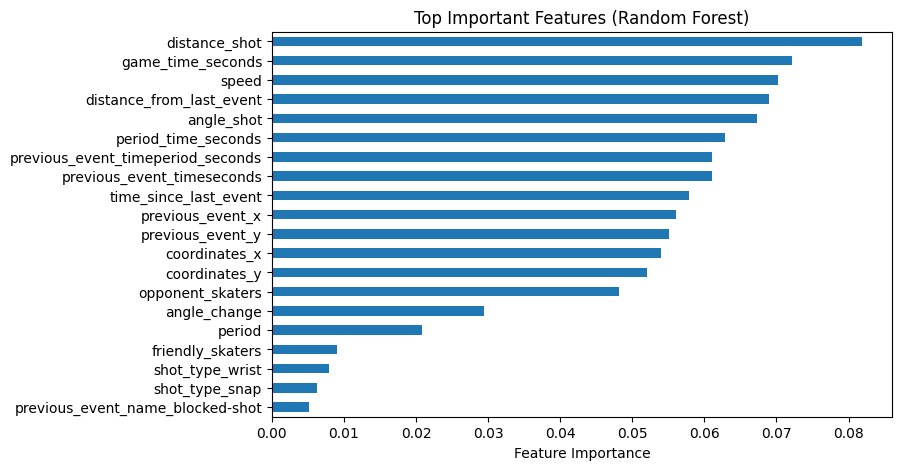

In [28]:
importance =  pd.Series(rf.feature_importances_, index=X_train_split1.columns)
importance = importance.sort_values(ascending=False)
print(importances.head(10))
plt.figure(figsize=(8, 5))
importances.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top Important Features (Random Forest)")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd

def _get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    else:
        raise ValueError("Model doesn't have predict_proba function.")


def plot_all_curves(models, X_val_dict, y_val_dict, n_bins=20):
    
    model_data = {}
    model_aucs = {}
    for name, model in models.items():
        if name not in X_val_dict or name not in y_val_dict:
            print(f"Warning: missing X_val or y_val for {name}, skipping.")
            continue

        X_val = X_val_dict[name]
        y_val = y_val_dict[name]

        y_score = _get_scores(model, X_val)
        auc = roc_auc_score(y_val, y_score)

        model_data[name] = {
            "y_true": np.asarray(y_val),
            "y_score": np.asarray(y_score),
        }
        model_aucs[name] = auc

    # 1. ROC CURVE + AUC
    plt.figure(figsize=(7, 5))
    for name, data in model_data.items():
        y_true = data["y_true"]
        y_score = data["y_score"]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = model_aucs[name]
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random baseline')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Validation set)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Goal Rate vs Probability Percentile
    plt.figure(figsize=(7, 5))
    for name, data in model_data.items():
        y_true = data["y_true"]
        y_score = data["y_score"]

        df_val = pd.DataFrame({"y_true": y_true, "y_pred": y_score})
        df_val["percentile"] = pd.qcut(
            df_val["y_pred"],
            n_bins,
            labels=False,
            duplicates="drop",
        )

        goal_rate = df_val.groupby("percentile")["y_true"].mean().values
        pctl = np.arange(len(goal_rate))

        plt.plot(pctl, goal_rate * 100, label=name)

    ax = plt.gca()
    ax.invert_xaxis()
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.ylim(0, 100)
    plt.xlabel("Predicted Probability Percentile (High → Left)")
    plt.ylabel("Goal Rate (%)")
    plt.title("Goal Rate vs Predicted Probability Percentile — Validation set")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. Cumulative Goals vs Shots
    plt.figure(figsize=(7, 5))
    for name, data in model_data.items():
        y_true = data["y_true"]
        y_score = data["y_score"]

        df_val = pd.DataFrame({"y_true": y_true, "y_pred": y_score})
        df_sorted = df_val.sort_values("y_pred", ascending=False).reset_index(drop=True)

        df_sorted["cum_goals"] = df_sorted["y_true"].cumsum()
        df_sorted["cum_goals_prop"] = df_sorted["cum_goals"] / df_sorted["y_true"].sum()
        df_sorted["cum_shots_prop"] = (np.arange(1, len(df_sorted) + 1)) / len(df_sorted)

        percentile_axis = (1.0 - df_sorted["cum_shots_prop"]) * 100.0
        cumulative_goal_percent = df_sorted["cum_goals_prop"] * 100.0

        plt.plot(percentile_axis, cumulative_goal_percent, label=name)

    ax = plt.gca()
    ax.invert_xaxis()
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.ylim(0, 100)
    plt.xlabel("Shot Probability Model Percentile")
    plt.ylabel("Cumulative % of Goals")
    plt.title("Cumulative Goal Proportion — Validation set")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Reliability (Calibration) Curve
    plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        y_true = data["y_true"]
        y_score = data["y_score"]

        prob_true, prob_pred = calibration_curve(
            y_true, y_score, n_bins=n_bins
        )

        plt.plot(
            prob_pred,
            prob_true,
            marker="o",
            label=f"{name} (AUC={model_aucs[name]:.3f})",
        )

    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Goal Frequency")
    plt.title("Reliability Curve - Validation")
    plt.legend()
    plt.show()


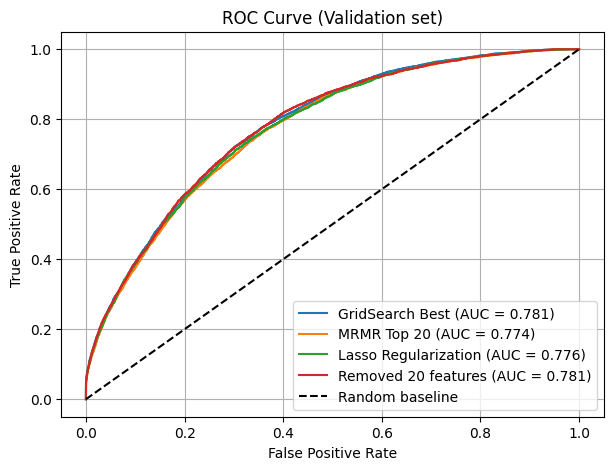

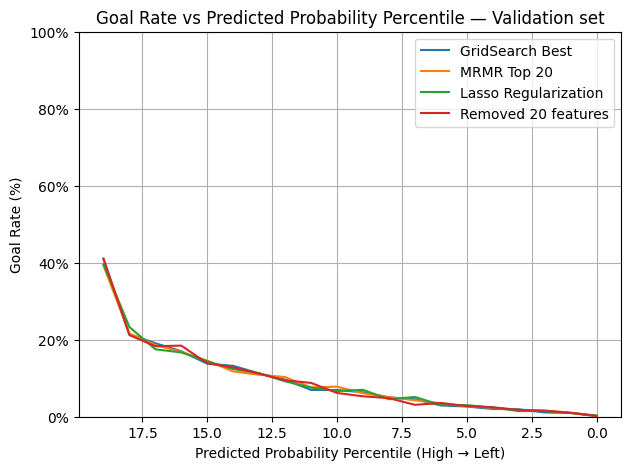

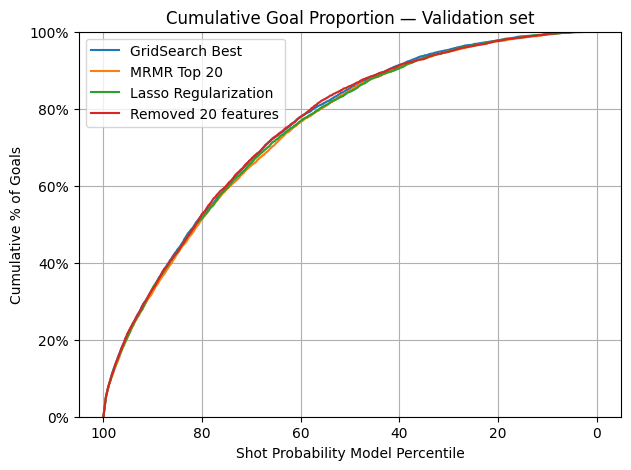

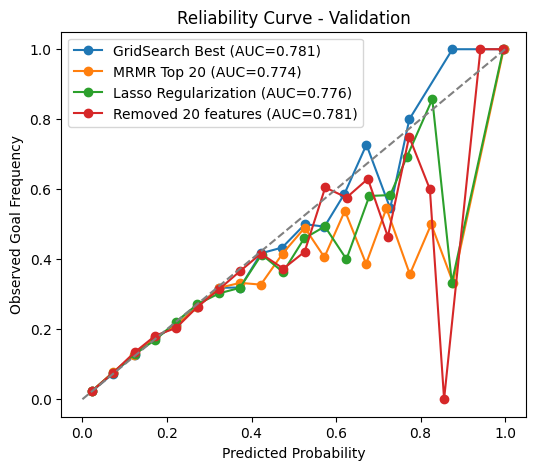

In [30]:
models = {
    "GridSearch Best": gr_best_model,
    "MRMR Top 20": mrmr_model,
    "Lasso Regularization": lasso_model,
    "Removed 20 features": rm_20_model
}

X_val = {
    "GridSearch Best": gr_X_val,
    "MRMR Top 20": mrmr_X_val,
    "Lasso Regularization": lasso_X_val,
    "Removed 20 features": rm_20_X_val
}

y_val = {
    "GridSearch Best": gr_y_val,
    "MRMR Top 20": mrmr_y_val,
    "Lasso Regularization": lasso_y_val,
    "Removed 20 features": rm_20_y_val
}


plot_all_curves(models, X_val, y_val)

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
import joblib
import wandb
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss, roc_curve
from sklearn.calibration import calibration_curve


def _get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    else:
        raise ValueError("Model has neither predict_proba nor decision_function.")


def _to_registry_name(name: str) -> str:
    return (
        name.lower()
        .replace(" ", "_")
        .replace("/", "_")
        .replace("(", "")
        .replace(")", "")
    )

def log_models_to_wandb(
    models,
    X_val_dict,
    y_val_dict,
    project="ift6758-2025-B01",
    api_key=None,
    entity=None,
    n_bins=20,
):
    api_key = os.getenv("WANDB_API_KEY", api_key)
    wandb.login(key=api_key)

    run = wandb.init(
        project=project,
        entity=entity,
        name="model-comparison",
        tags=["nhl-shots", "binary-classification", "calibration"],
        config={"models": list(models.keys())},
        reinit=True,
    )

    run_info = {}
    model_data = {}

    for name, model in models.items():
        if name not in X_val_dict or name not in y_val_dict:
            print(f"[W&B] Skipping {name}: no matching X_val/y_val")
            continue

        X_val = X_val_dict[name]
        y_val = y_val_dict[name]

        y_score = _get_scores(model, X_val)
        y_pred = (y_score > 0.5).astype(int)

        acc = accuracy_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_score)
        brier = brier_score_loss(y_val, y_score)

        registry_name = _to_registry_name(name)

        wandb.log(
            {
                f"{registry_name}/accuracy": acc,
                f"{registry_name}/roc_auc": roc_auc,
                f"{registry_name}/brier": brier,
            }
        )

        with tempfile.TemporaryDirectory() as tmpdir:
            model_path = os.path.join(tmpdir, "model.joblib")
            joblib.dump(model, model_path)
            run.log_model(
                name=registry_name,
                path=model_path,
            )

        run_info[name] = {
            "roc_auc": roc_auc,
            "accuracy": acc,
            "brier": brier,
            "registry_name": registry_name,
        }

        model_data[name] = {
            "y_true": np.asarray(y_val),
            "y_score": np.asarray(y_score),
            "roc_auc": roc_auc,
        }

        print(f"[W&B] Logged and registered {name} as '{registry_name}'")

    if not model_data:
        run.finish()
        return run_info

    # 1 - ROC Curve (all models)
    fig_roc = plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        fpr, tpr, _ = roc_curve(data["y_true"], data["y_score"])
        plt.plot(fpr, tpr, label=f"{name} (AUC={data['roc_auc']:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve — Validation")
    plt.legend()
    wandb.log({"plots/roc_curve": wandb.Image(fig_roc)})
    plt.close(fig_roc)

    # 2 - Goal Rate vs Probability Percentile (all models)
    fig_goal = plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        df_val = pd.DataFrame({"y_true": data["y_true"], "y_pred": data["y_score"]})
        df_val["percentile"] = pd.qcut(
            df_val["y_pred"], n_bins, labels=False, duplicates="drop"
        )
        goal_rate = df_val.groupby("percentile")["y_true"].mean()
        plt.plot(
            goal_rate.index,
            goal_rate.values,
            marker="o",
            label=f"{name} (AUC={data['roc_auc']:.3f})",
        )
    plt.xlabel("Predicted Probability Percentile (0=Low, n_bins-1=High)")
    plt.ylabel("Actual Goal Rate")
    plt.title("Goal Rate vs Probability Percentile — Validation")
    plt.legend()
    wandb.log({"plots/goal_rate_vs_percentile": wandb.Image(fig_goal)})
    plt.close(fig_goal)

    # 3 - Cumulative Goals vs Shots (all models)
    fig_cum = plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        df_val = pd.DataFrame({"y_true": data["y_true"], "y_pred": data["y_score"]})
        df_sorted = df_val.sort_values("y_pred", ascending=False)
        df_sorted["cum_goals"] = df_sorted["y_true"].cumsum()
        df_sorted["cum_goals_prop"] = df_sorted["cum_goals"] / df_sorted[
            "y_true"
        ].sum()
        df_sorted["cum_shots_prop"] = (
            np.arange(1, len(df_sorted) + 1) / len(df_sorted)
        )
        plt.plot(
            df_sorted["cum_shots_prop"],
            df_sorted["cum_goals_prop"],
            label=f"{name} (AUC={data['roc_auc']:.3f})",
        )
    plt.xlabel("Cumulative Proportion of Shots")
    plt.ylabel("Cumulative Proportion of Goals")
    plt.title("Cumulative Goals vs Shots — Validation")
    plt.legend()
    wandb.log({"plots/cumulative_goals_vs_shots": wandb.Image(fig_cum)})
    plt.close(fig_cum)

    # 4 - Reliability (Calibration) Curve (all models)
    fig_cal = plt.figure(figsize=(6, 5))
    for name, data in model_data.items():
        prob_true, prob_pred = calibration_curve(
            data["y_true"], data["y_score"], n_bins=n_bins)
        plt.plot(
            prob_pred,
            prob_true,
            marker="o",
            label=f"{name} (AUC={data['roc_auc']:.3f})",
        )
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Goal Frequency")
    plt.title("Reliability Curve — Validation")
    plt.legend()
    wandb.log({"plots/reliability_curve": wandb.Image(fig_cal)})
    plt.close(fig_cal)

    print(f"[W&B] Run URL: {run.url}")
    run.finish()

    return run_info

In [32]:
models = {
    "GridSearch Best": gr_best_model,
    "MRMR Top 20": mrmr_model,
    "Lasso Regularization": lasso_model,
    "Removed 20 features": rm_20_model
}

X_val = {
    "GridSearch Best": gr_X_val,
    "MRMR Top 20": mrmr_X_val,
    "Lasso Regularization": lasso_X_val,
    "Removed 20 features": rm_20_X_val
}

y_val = {
    "GridSearch Best": gr_y_val,
    "MRMR Top 20": mrmr_y_val,
    "Lasso Regularization": lasso_y_val,
    "Removed 20 features": rm_20_y_val
}

run_info = log_models_to_wandb(
    models=models,
    X_val_dict=X_val,
    y_val_dict=y_val,
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Goofy\_netrc
wandb: Currently logged in as: gafran-ijaz (IFT6758-2025-B1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[W&B] Logged and registered GridSearch Best as 'gridsearch_best'
[W&B] Logged and registered MRMR Top 20 as 'mrmr_top_20'
[W&B] Logged and registered Lasso Regularization as 'lasso_regularization'
[W&B] Logged and registered Removed 20 features as 'removed_20_features'
[W&B] Run URL: https://wandb.ai/IFT6758-2025-B1/IFT6758-2025-B01/runs/2x83dqx3


gridsearch_best/accuracy,▁
gridsearch_best/brier,▁
gridsearch_best/roc_auc,▁
lasso_regularization/accuracy,▁
lasso_regularization/brier,▁
lasso_regularization/roc_auc,▁
mrmr_top_20/accuracy,▁
mrmr_top_20/brier,▁
mrmr_top_20/roc_auc,▁
removed_20_features/accuracy,▁
+2,...
